# Multi-stocks analysis using clustring for GICS sectors

Nowadays, Sector Exchange-Traded Funds (ETFs) are investment funds that track the performance of specific sectors within the market, such as Information Technology, Health Care, or Energy. These ETFs allow investors to gain targeted exposure to a particular sector without having to invest in individual stocks. The Global Industry Classification Standard (GICS) framework divides the market into 11 sectors, making it easier for investors to analyze and allocate their investments.

## This is an analysis system for evaluating performance of stocks in different sectors

According to GICS criterion, stocks in S&P500 are divided into sectors as below:

* Information Technology (IT)
* Health Care
* Financials
* Consumer Discretionary
* Communication Services
* Industrials
* Consumer Staples
* Energy
* Utilities
* Real Estate
* Materials


Using a LightGBM model, the system predicts the net return of stocks over a T+7 day period based on a season-long dataset. The results are visualized using violin plots, providing a clear view of return distributions across sectors.

This analysis helps investors make informed decisions when buying sector-specific ETFs, enabling targeted exposure to high-performing sectors while maintaining diversification.



In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import argparse
from datetime import datetime
import lightgbm as lgb
from utils import *
from get_tickers import *
from factors_lib import *


# Construct the info Dataframe

In [9]:
stock_tickers_info = get_sp500_stockinfo_df()
tickers_list = list(stock_tickers_info['Symbol'])
sector_list = list(stock_tickers_info['GICS Sector'])


all_data_df = None
for ticker in tickers_list:
    try:
        start = "2024-07-01"
        stock_data = yf.download(ticker, start=start, end=datetime.today())
        stock_data['CotractId'] = ticker
        stock_data['Sector'] = sector_list[tickers_list.index(ticker)]
        
        stock_data["OpenPrice"] = stock_data["Open"]
        stock_data["ClosePrice"] = stock_data["Close"]
        stock_data["LowPrice"] = stock_data["Low"]
        stock_data["HighPrice"] = stock_data["High"]

        # label: return in a trading week (5 days, usually)
        stock_data["Return"] = (stock_data["ClosePrice"] - stock_data["ClosePrice"].values[0])/ stock_data["ClosePrice"].values[0] * 100
        stock_data["Return"] = stock_data["Return"].copy().shift(-5).fillna(0)

        # prepare for factors
        stock_data["STR"] = Short_Term_Reversion(df=stock_data, cal_choose="Close", n_days=5).fillna(0)
        stock_data["FRX"] = ForceIndex(pool_df=stock_data)
        stock_data["OSS"] = Oversold_Reverse_Score(df=stock_data)
        stock_data["CCG"] = CCG_Score(stock_data)
        stock_data["ILLIQ"] = ILLIQ_Factor(stock_data, 9)

        # standardlise data
        feature_list = ['OpenPrice', 'ClosePrice', 'LowPrice', 'HighPrice','Volume', 'STR', 'FRX', 'OSS', 'CCG', 'ILLIQ']

        if all_data_df is None:
            all_data_df = stock_data
        else:
            all_data_df = pd.concat([all_data_df, stock_data])


    except Exception as e:
        # Log the error and continue
        print(f"Failed to download data for {ticker}: {e}")
        continue
    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Failed to download data for BRK.B: index 0 is out of bounds for axis 0 with size 0


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BF.B']: YFPr

Failed to download data for BF.B: index 0 is out of bounds for axis 0 with size 0


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:


result_dict = {}
for SECTOR in set(sector_list):
    
    sector_stock_data = all_data_df[all_data_df['Sector'] == SECTOR].copy()
    sector_stock_data['Date'] = pd.to_datetime(sector_stock_data.index)
    stock_number = len(set(sector_stock_data['CotractId']))
    print(f"{SECTOR} sector, stock number: {stock_number}")

    
    Train_X = sector_stock_data[feature_list].copy().values[:-5]
    Train_y = sector_stock_data['Return'].values[:-5]

    Train_X = np.array(Train_X)
    Train_y = np.array(Train_y)

    model = lgb.LGBMRegressor()
    model.fit(Train_X, Train_y)
    
    recent_data = sector_stock_data[sector_stock_data['Date'] == sector_stock_data['Date'].iloc[-1]].copy()
    recent_data_X  = np.array(recent_data[feature_list].values)
    u = model.predict(recent_data_X)

    # delete the extreme value
    mean = np.mean(u)
    std_dev = np.std(u)
    u = u[u >= mean - 3 * std_dev]
    filtered_u = np.array(u[u <= mean + 3 * std_dev])
    result_dict[SECTOR] = filtered_u
    

Materials sector, stock number: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2319
[LightGBM] [Info] Number of data points in the train set: 3295, number of used features: 10
[LightGBM] [Info] Start training from score 5.013952
Consumer Discretionary sector, stock number: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2318
[LightGBM] [Info] Number of data points in the train set: 5895, number of used features: 10
[LightGBM] [Info] Start training from score 8.081890
Industrials sector, stock number: 78
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2320
[L

# Plot the result with Violin plot

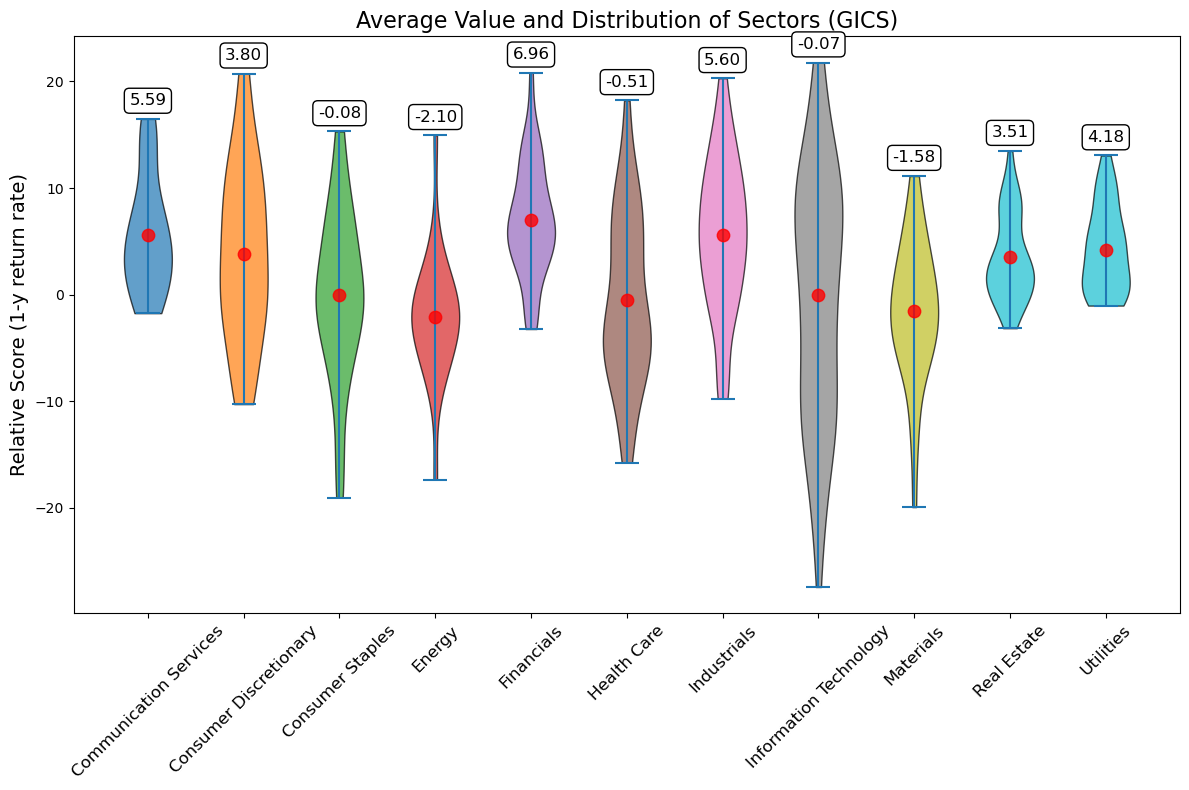

In [11]:
import collections
data = result_dict
data = collections.OrderedDict(sorted(data.items()))

colors = plt.cm.tab10(range(len(data)))
categories = list(data.keys())
values = list(data.values())
means = [np.mean(v) for v in values]
maxs = [np.max(v) for v in values]


plt.figure(figsize=(12, 8))
parts = plt.violinplot(values, showmeans=False, showextrema=True, showmedians=False)

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

plt.scatter(range(1, len(categories) + 1), means, s=80, alpha=0.8, color='red', label='Mean Values', zorder=3)
for i, mean in enumerate(means):
    plt.text(
        i+1, maxs[i]+1, f'{mean:.2f}', 
        color='black', ha='center', va='bottom', fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
    )
    
plt.xticks(ticks=np.arange(1, len(categories) + 1), labels=categories, rotation=45, fontsize=12)
plt.title('Average Value and Distribution of Sectors (GICS)', fontsize = 16)
plt.ylabel('Relative Score (1-y return rate)', fontsize = 14)
plt.tight_layout()